# MOGP experiment on Finance dataset
## Oil, Gold, NASDAQ, and USD-index dataset

This notebook ilustrate the toolkit use on a real-world finance dataset, taking the weekly price of the Gold, Oil, NASDAQ and USD.

For this 4-output time series we fit three different multioutput Gaussian Processes and show the results.

For each model we optimize we repeat the experiment 5 times, to ensure robustness in the optimization and prediction.


- Oil: Brent daily in USD from https://www.eia.gov/dnav/pet/hist/RBRTEd.htm
- Gold: LMBA gold daily at 10:30AM in USD from https://fred.stlouisfed.org/series/GOLDAMGBD228NLBM
- NASDAQ: adjusted closing price (daily) from https://finance.yahoo.com/quote/%5EIXIC/history?p=%5EIXIC
- USD index: traded weighted on broad currency index from https://fred.stlouisfed.org/series/TWEXB

In [1]:
import sys
sys.path.insert(0, '../')
%reload_ext autoreload
%autoreload 2

import mogptk
import gpflow

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime

# plot config
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (12, 6)

### Load Dataset

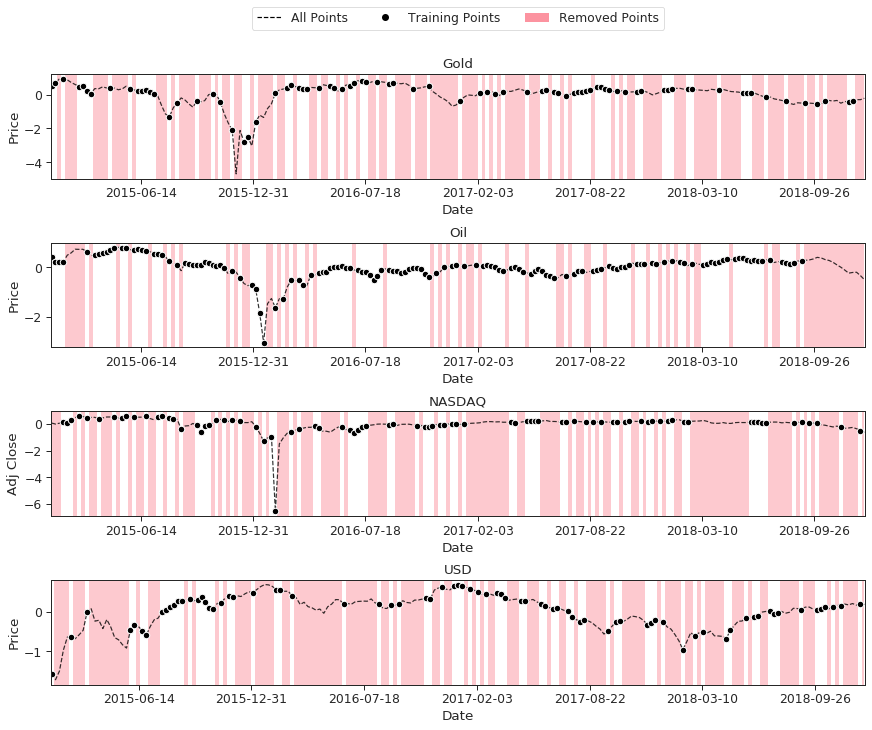

In [2]:
oil = mogptk.LoadCSV('data/gonu/brent-daily.csv',
                     'Date',
                     'Price',
                     name='Oil',
                     formats={'Date': mogptk.FormatDate})
gold = mogptk.LoadCSV('data/gonu/lmba-gold-usd-am-daily.csv',
                      'Date',
                      'Price',
                      name='Gold',
                      formats={'Date': mogptk.FormatDate},
                      na_values='.')
nasdaq = mogptk.LoadCSV('data/gonu/nasdaq.csv',
                        'Date',
                        'Adj Close',
                        name='NASDAQ',
                        formats={'Date': mogptk.FormatDate})
usd = mogptk.LoadCSV('data/gonu/TWEXB.csv',
                     'Date',
                     'Price',
                     name='USD',
                     formats={'Date': mogptk.FormatDate})

cols = ['Gold', 'Oil', 'NASDAQ', 'USD']
dataset = mogptk.DataSet(gold, oil, nasdaq, usd)

# Remove points randomly to simulate sensor failure
np.random.seed(1)
for i, channel in enumerate(dataset):
    channel.filter('2015-01-01', '2018-12-31')
    channel.aggregate('7d')
    
    channel.transform(mogptk.TransformLog())
    channel.transform(mogptk.TransformDetrend())
    
    if i == 0:
        channel.remove_range('2016-11-15', '2017-01-01')
        channel.remove_randomly(pct=0.6)
    if i == 1:
        channel.remove_range('2018-10-05', None)
        channel.remove_randomly(pct=0.3)
    if i == 2:
        channel.remove_randomly(pct=0.6)
    if i == 3:
        channel.remove_range('2016-03-15', '2016-06-01')
        channel.remove_randomly(pct=0.6)
        
dataset.plot()
x_test, y_test = dataset.get_test_data()

## MOSM

The first model is the MultiOutput Spectral Mixture kernel

In [3]:
n_trials = 1

# result containers
mosm_list = []
mosm_mae = np.zeros((n_trials, len(cols)))
mosm_nmae = np.zeros((n_trials, len(cols)))
mosm_rmse = np.zeros((n_trials, len(cols)))
mosm_nrmse = np.zeros((n_trials, len(cols)))

# experiment trials
for n in range(n_trials):
    model_mosm = mogptk.MOSM(dataset, Q=3)
    model_mosm.init_parameters('BNSE')
    
    print('Starting trial', n)
    model_mosm.train(method='L-BFGS-B', maxiter=2000, tol=1e-20, verbose=True)
    print('='*50)
    
    mosm_list.append(model_mosm)
    
    # errors per channel
    error = mogptk.test_errors(model_mosm, x_test=x_test, y_test=y_test)
    
    mosm_mae[n, :] = np.array(error[0])[:, 0]
    mosm_nmae[n, :] = np.array(error[0])[:, 1]
    mosm_rmse[n, :] = np.array(error[0])[:, 2]
    mosm_nrmse[n, :] = np.array(error[0])[:, 3]

Starting trial 0
Starting optimization
 >Model: MOSM
 >Channels: 4                    
 >Components: 3
 >Training points: 382
 >Parameters: 65
 >Initial NLL: 416.625
Optimization finished in 4.85 minutes
 >Final NLL: -136.049 



In [4]:
pd.DataFrame(np.c_[mosm_mae.mean(0), mosm_nmae.mean(0), mosm_rmse.mean(0), mosm_nrmse.mean(0),
                             mosm_mae.std(0), mosm_nmae.std(0), mosm_rmse.std(0), mosm_nrmse.std(0)],
                       columns=['MAE', 'nmae', 'RMSE', 'NRMSE', 'MAE std', 'nmae% std', 'RMSE std', 'NRMSE std'])

,MAE,nmae,RMSE,NRMSE,MAE std,nmae% std,RMSE std,NRMSE std
0,19.194876,0.065948,27.095593,0.093093,0.0,0.0,0.0,0.0
1,3.606586,0.067099,5.895266,0.109679,0.0,0.0,0.0,0.0
2,518.564249,0.144462,997.305362,0.277830,0.0,0.0,0.0,0.0
3,0.669643,0.039617,0.863993,0.051115,0.0,0.0,0.0,0.0


Plot the best model

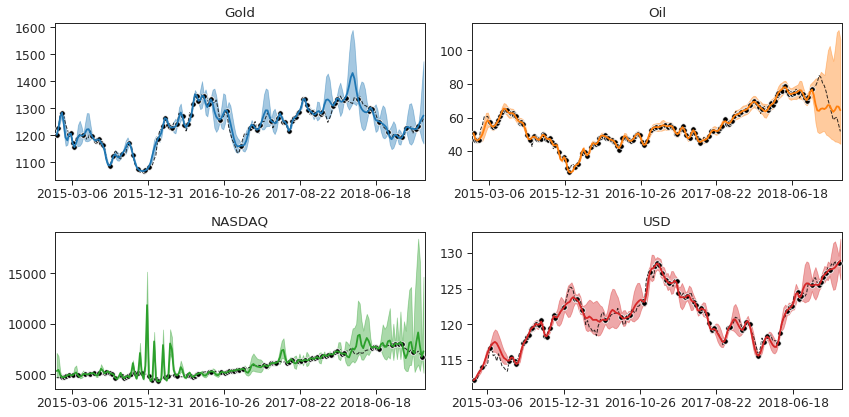

In [6]:
best_mosm = mosm_list[np.argmin(mosm_nmae.mean(1))]

x_pred = [channel.get_data()[0] for channel in dataset]
best_mosm.predict(x_pred)

f, axarr, = best_mosm.plot_prediction(
                       grid=(2, 2),
                       names=cols,
                       title='',
                       figsize=(12, 6));

Uncomment for better plot

In [6]:
# ylims = [(40, 92), (1150, 1400), (5300, 8300), (114, 131)]

# best_mosm.predict(x_pred)

# f, axarr, = best_mosm.plot_prediction(
#                        grid=(2, 2),
#                        names=cols,
#                        title='',
#                        ylims=ylims,
#                        figsize=(12, 4));

# yticks = [(50, 80), (1200, 1350), (5400, 8100), (117, 127)]

# for i in range(len(cols)):
#     axarr[i].set_title(cols[i], fontsize=15)
#     axarr[i].set_yticks(np.linspace(yticks[i][0], yticks[i][1], 3))

#     channel = best_mosm.dataset[i]

#     xlabels = pd.date_range('2015-01-01', '2018-12-31', periods=9).date
#     xticks = [channel.formatters[0].parse(str(label)) for label in xlabels]
    
#     new_xlabels = ['']*9
#     xlabels[::2][2:] += datetime.timedelta(days=1)
#     new_xlabels[::2] = xlabels[::2]
    
#     axarr[i].set_xticks(xticks)
    
#     if i>= 2:
#          axarr[i].set_xticklabels(new_xlabels)
        
#     else:
#          axarr[i].set_xticklabels([])
#     axarr[i].set_xlim(xticks[4], xticks[-1])
    
#     xlabel_list = [item for item in axarr[i].get_xticklabels()]
    
#     if i>=2:
#         xlabel_list[4].set_ha('left')
#         xlabel_list[-1].set_ha('right')

# plt.tight_layout()
    
# plt.savefig('output/mosm_gonu.pdf', bbox_inches='tight')

### Autocorrelation vs Kernel evaluation

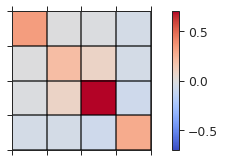

In [22]:
# obtain gram matrix
_, _, gram_matrix = best_mosm.plot_gram_matrix(0, 0, 1, retmatrix=True, figsize=(3, 3))

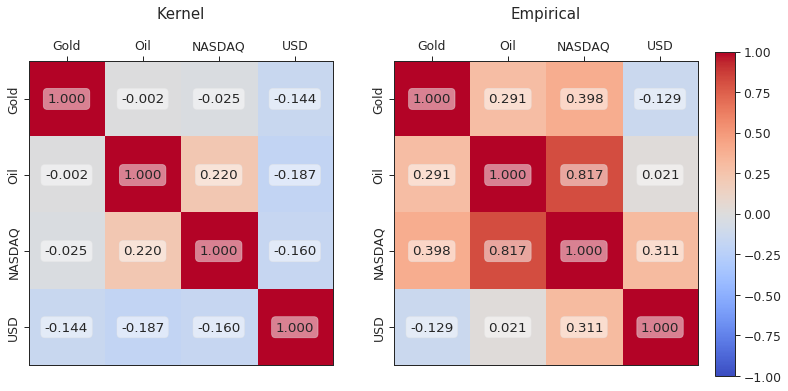

In [24]:
# autocorrelation
x_all, y_all = best_mosm.dataset.get_data()
y_all_array = np.empty((207, 0))
for y in y_all:
    y_all_array = np.c_[y_all_array, y[:207]]
auto_corr = np.corrcoef(y_all_array.T)

# normalize gram matrix
sqrt_diag = np.sqrt(np.diag(gram_matrix))
norm_gram_matrix = gram_matrix / np.outer(sqrt_diag, sqrt_diag)

f, axarray = plt.subplots(1, 2, figsize=(12, 8))
color_range = max(np.abs(norm_gram_matrix).max(), np.abs(auto_corr).max())

im = axarray[0].matshow(norm_gram_matrix, cmap='coolwarm', vmin=-color_range, vmax=color_range)
for (i, j), z in np.ndenumerate(norm_gram_matrix):
    axarray[0].text(j, i, '{:0.3f}'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.9'))
axarray[0].set_title('Kernel', y=1.12, fontsize=15)

im = axarray[1].matshow(auto_corr, cmap='coolwarm', vmin=-color_range, vmax=color_range)

for (i, j), z in np.ndenumerate(auto_corr):
    axarray[1].text(j, i, '{:0.3f}'.format(z), ha='center', va='center', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.9'))
axarray[1].set_title('Empirical', y=1.12, fontsize=15)
axarray[0].set_yticks(np.arange(4));
axarray[0].set_yticklabels(cols, rotation=90, va='center');
axarray[0].set_xticks(np.arange(4));
axarray[0].set_xticklabels(cols);
axarray[0].xaxis.set_ticks_position('top')

axarray[1].set_yticks(np.arange(4));
axarray[1].set_yticklabels(cols, rotation=90, va='center');
axarray[1].set_xticks(np.arange(4));
axarray[1].set_xticklabels(cols);
axarray[1].xaxis.set_ticks_position('top')

cbar_ax = f.add_axes([.92, 0.22, 0.023, 0.563])
f.colorbar(im, cax=cbar_ax)

# plt.savefig('output/autocorr_double.pdf', bbox_inches='tight')

## CSM

In [31]:
n_trials = 1

csm_mae = np.zeros((n_trials, len(cols)))
csm_nmae = np.zeros((n_trials, len(cols)))
csm_rmse = np.zeros((n_trials, len(cols)))
csm_nrmse = np.zeros((n_trials, len(cols)))
csm_list = []

for n in range(n_trials):
    model_csm = mogptk.CSM(dataset, Q=3)
    model_csm.init_parameters('BNSE')
    
    print('Starting trial', n)
    model_csm.train(method='L-BFGS-B', maxiter=2000, tol=1e-40, verbose=True)
    print('Finished trial', n)
    print('='*50)
    csm_list.append(model_csm)
    
    # errors per channel
    error = mogptk.test_errors(model_csm, x_test=x_test, y_test=y_test)
    
    csm_mae[n, :] = np.array(error[0])[:, 0]
    csm_nmae[n, :] = np.array(error[0])[:, 1]
    csm_rmse[n, :] = np.array(error[0])[:, 2]
    csm_nrmse[n, :] = np.array(error[0])[:, 3]

Starting trial 0
Starting optimization
 >Model: CSM
 >Channels: 4                    
 >Components: 3
 >Training points: 382
 >Parameters: 35
 >Initial NLL: 439.972
Optimization finished in 1.73 minutes
 >Final NLL: 16.762 

Finished trial 0


In [32]:
pd.DataFrame(np.c_[csm_mae.mean(0), csm_nmae.mean(0), csm_rmse.mean(0), csm_nrmse.mean(0),
                   csm_mae.std(0), csm_nmae.std(0), csm_rmse.std(0), csm_nrmse.std(0)],
             columns=['MAE', 'nmae', 'RMSE', 'NRMSE', 'MAE std', 'nmae% std', 'RMSE std', 'NRMSE std'])

,MAE,nmae,RMSE,NRMSE,MAE std,nmae% std,RMSE std,NRMSE std
0,16.630507,0.057138,22.419439,0.077027,0.0,0.0,0.0,0.0
1,3.484988,0.064837,5.722711,0.106469,0.0,0.0,0.0,0.0
2,366.819306,0.102189,497.765071,0.138668,0.0,0.0,0.0,0.0
3,1.536838,0.090922,2.525219,0.149396,0.0,0.0,0.0,0.0


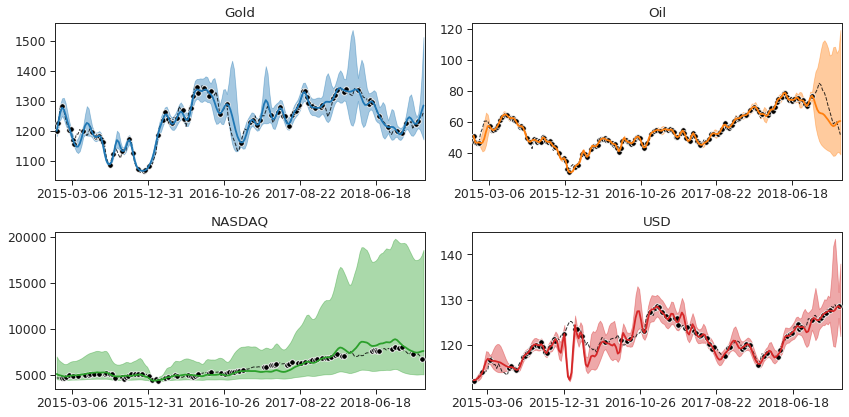

In [33]:
best_csm = csm_list[np.argmin(csm_nmae.mean(1))]
best_csm.predict(x_pred)
best_csm.plot_prediction(grid=(2, 2),
                         names=cols,
                         title='',
                         figsize=(12, 6));

## SM-LMC

In [28]:
n_trials = 1

smlmc_mae = np.zeros((n_trials, len(cols)))
smlmc_nmae = np.zeros((n_trials, len(cols)))
smlmc_rmse = np.zeros((n_trials, len(cols)))
smlmc_nrmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    model_smlmc = mogptk.SM_LMC(dataset, Q=3)
    model_smlmc.init_parameters('BNSE')
    print('='*50)
    
    model_smlmc.train(method='L-BFGS-B', maxiter=2000, tol=1e-40, verbose=True)
    
    error = mogptk.test_errors(model_smlmc, x_test=x_test, y_test=y_test)
    
    smlmc_mae[n, :] = np.array(error[0])[:, 0]
    smlmc_nmae[n, :] = np.array(error[0])[:, 1]
    smlmc_rmse[n, :] = np.array(error[0])[:, 2]
    smlmc_nrmse[n, :] = np.array(error[0])[:, 3]

Trial  0
Starting optimization
 >Model: SM-LMC
 >Channels: 4                    
 >Components: 3
 >Training points: 382
 >Parameters: 23
 >Initial NLL: 420.004
Optimization finished in 0.56 minutes
 >Final NLL: -7.525 



In [34]:
pd.DataFrame(np.c_[smlmc_mae.mean(0), smlmc_nmae.mean(0), smlmc_rmse.mean(0), smlmc_nrmse.mean(0),
                   smlmc_mae.std(0), smlmc_nmae.std(0), smlmc_rmse.std(0), smlmc_nrmse.std(0)],
             columns=['MAE', 'nmae%', 'RMSE', 'NRMSE','MAE std', 'nmae% std', 'RMSE std', 'NRMSE std'])

,MAE,nmae%,RMSE,NRMSE,MAE std,nmae% std,RMSE std,NRMSE std
0,18.443741,0.063367,26.802816,0.092087,0.0,0.0,0.0,0.0
1,3.715582,0.069127,6.252165,0.116319,0.0,0.0,0.0,0.0
2,348.050298,0.096960,447.403319,0.124638,0.0,0.0,0.0,0.0
3,0.710037,0.042007,0.905531,0.053573,0.0,0.0,0.0,0.0


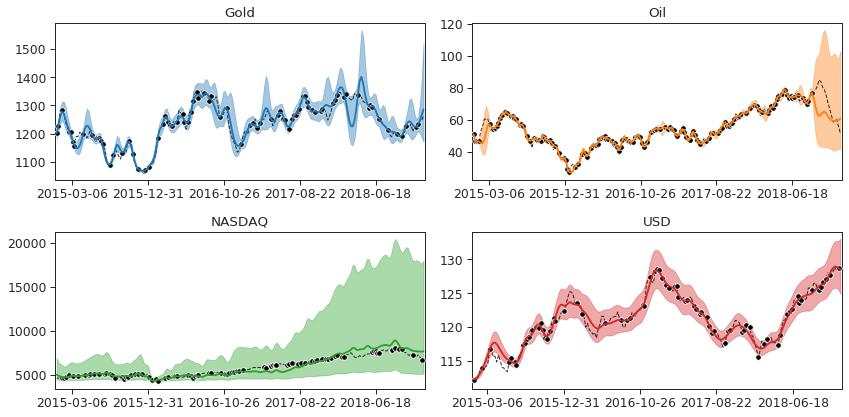

In [36]:
model_smlmc.predict(x_pred)
model_smlmc.plot_prediction(grid=(2, 2),
                       names=cols,
                       title='',
                       figsize=(12, 6));

# IGP
Independent GP with SM kernels

In [37]:
n_trials = 1

igp_mae = np.zeros((n_trials, len(cols)))
igp_nmae = np.zeros((n_trials, len(cols)))
igp_rmse = np.zeros((n_trials, len(cols)))
igp_nrmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    
    igp_list = []
    
    for i in range(len(cols)):
        model_sm = mogptk.SM(dataset[i], Q=3)
        model_sm.init_parameters('BNSE')
        model_sm.train(method='L-BFGS-B', maxiter=2000, tol=1e-40, verbose=True)
        
        igp_list.append(model_sm)
        
        error = mogptk.test_errors(model_sm, x_test=[x_test[i]], y_test=[y_test[i]])
    
        igp_mae[n, i] = np.array(error[0])[:, 0]
        igp_nmae[n, i] = np.array(error[0])[:, 1]
        igp_rmse[n, i] = np.array(error[0])[:, 2]
        igp_nrmse[n, i] = np.array(error[0])[:, 3]
    print('='*50)    

Trial  0
Starting optimization
 >Model: SM
 >Channels: 1                    
 >Components: 3
 >Training points: 82
 >Parameters: 10
 >Initial NLL: 93.299
Optimization finished in 0.02 minutes
 >Final NLL: 8.706 

Starting optimization
 >Model: SM
 >Channels: 1                    
 >Components: 3
 >Training points: 139
 >Parameters: 10
 >Initial NLL: 144.166
Optimization finished in 0.01 minutes
 >Final NLL: -63.223 

Starting optimization
 >Model: SM
 >Channels: 1                    
 >Components: 3
 >Training points: 84
 >Parameters: 10
 >Initial NLL: 110.028
Optimization finished in 0.02 minutes
 >Final NLL: 89.719 

Starting optimization
 >Model: SM
 >Channels: 1                    
 >Components: 3
 >Training points: 77
 >Parameters: 10
 >Initial NLL: 79.384
Optimization finished in 0.02 minutes
 >Final NLL: -36.002 



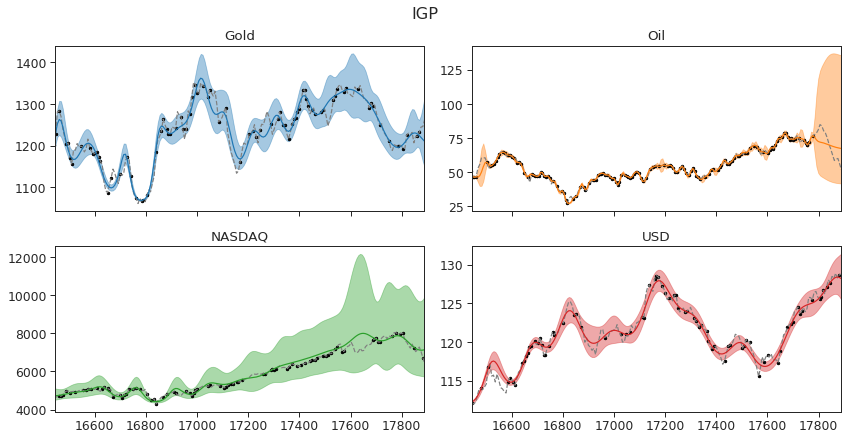

In [38]:
# plot prediction

f, axarr = plt.subplots(2, 2, sharex=True, figsize=(12, 6))
axarr = axarr.reshape(-1)

for i in range(len(cols)):
    c = igp_list[i].dataset[0]
    
    x_train, y_train = igp_list[i].dataset.get_train_data()
    x_all, y_all = igp_list[i].dataset.get_data()
    
    x_train = x_train[0]
    y_train = y_train[0]
    
    x_all = x_all[0]
    y_all = y_all[0]
    
    x_pred = x_all
    mean_pred, lower_ci, upper_ci = igp_list[i].predict([x_pred])
    
    axarr[i].plot(x_train[:, 0], y_train, '.k', label='Train', )
    axarr[i].plot(x_all[:, 0], y_all, '--', label='Test', c='gray')

    axarr[i].plot(x_pred[:, 0], mean_pred[0], label='Post.Mean', c=sns.color_palette()[i%10])
    axarr[i].fill_between(x_pred[:, 0].reshape(-1),
                          lower_ci[0],
                          upper_ci[0],
                          label='95% c.i',
                          color=sns.color_palette()[i%10],
                          alpha=0.4)
    axarr[i].set_xlim(x_all[0]-1, x_all[-1])
    # set channels name
    axarr[i].set_title(cols[i])

plt.suptitle('IGP', y=1.02)
plt.tight_layout()

## Results

In [43]:
print('mosm nMAE {:.3e} pm {:.3e} | mosm nRMSE {:.3e} pm {:.3e}'.format(
        mosm_nmae.mean(1).mean(),
        mosm_nmae.mean(1).std(),
        mosm_nrmse.mean(1).mean(),
        mosm_nrmse.mean(1).std()))

mosm nMAE 7.928e-02 pm 0.000e+00 | mosm nRMSE 1.329e-01 pm 0.000e+00


In [44]:
print('csm nMAE {:.3e} pm {:.3e} | csm nRMSE {:.3e} pm {:.3e}'.format(
        csm_nmae.mean(1).mean(),
        csm_nmae.mean(1).std(),
        csm_nrmse.mean(1).mean(),
        csm_nrmse.mean(1).std()))

csm nMAE 7.877e-02 pm 0.000e+00 | csm nRMSE 1.179e-01 pm 0.000e+00


In [45]:
print('smlmc nMAE {:.3e} pm {:.3e} | smlmc nRMSE {:.3e} pm {:.3e}'.format(
        smlmc_nmae.mean(1).mean(),
        smlmc_nmae.mean(1).std(),
        smlmc_nrmse.mean(1).mean(),
        smlmc_nrmse.mean(1).std()))

smlmc nMAE 6.787e-02 pm 0.000e+00 | smlmc nRMSE 9.665e-02 pm 0.000e+00


In [46]:
print('igp nMAE {:.3e} pm {:.3e} | igp nRMSE {:.3e} pm {:.3e}'.format(
        igp_nmae.mean(1).mean(),
        igp_nmae.mean(1).std(),
        igp_nrmse.mean(1).mean(),
        igp_nrmse.mean(1).std()))

igp nMAE 5.222e-02 pm 0.000e+00 | igp nRMSE 7.287e-02 pm 0.000e+00
